<a href="https://colab.research.google.com/github/alexrafkin/ideal-parakeet/blob/main/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

le_orig = pd.read_sql_query('select * from lifeexpectancy',con=engine)
engine.dispose()

In [ ]:
le = le_orig.copy()

NameError: ignored

In [ ]:
le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

We can see there are no object data types where we are expecting a numeric data type - that means we can expect nan for nulls. However we still need to check for data entry errors.

In [ ]:
def percent_null(df):
  return df.isnull().sum()*100/df.isnull().count()

percent_null(le)

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

1. Detect the problems with the data, such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable for filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

We can see there are a bunch of missing values from our initial le.info()

In [ ]:
avgs = le.groupby("Country").mean()

In [ ]:
fill_list = list(le.columns)
fill_list.remove('Country')
fill_list.remove('Year')
fill_list.remove('Status')
fill_list.remove('infant deaths')
fill_list.remove('percentage expenditure')
fill_list.remove('under-five deaths ')
fill_list.remove(' HIV/AIDS')
print(fill_list)

['Life expectancy ', 'Adult Mortality', 'Alcohol', 'Hepatitis B', 'Measles ', ' BMI ', 'Polio', 'Total expenditure', 'Diphtheria ', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']


In [ ]:
countries = le["Country"].unique()

for country in countries:
    le.loc[le["Country"] == country, fill_list] = le.loc[le["Country"] == country, fill_list].interpolate()

for col in fill_list:
    for country in countries:
        le.loc[le["Country"] == country, col] = le.loc[le["Country"] == country, col].fillna(le[le["Country"] == country][col].mean())

le=le.dropna()

In [ ]:
percent_null(le)

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
 BMI                               0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
 HIV/AIDS                          0.0
GDP                                0.0
Population                         0.0
 thinness  1-19 years              0.0
 thinness 5-9 years                0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

In [ ]:
fill_list2 = list(le.columns)
fill_list2.remove('Country')
fill_list2.remove('Year')
fill_list2.remove('Status')

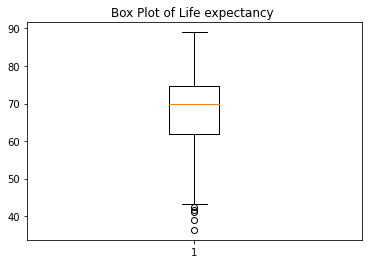

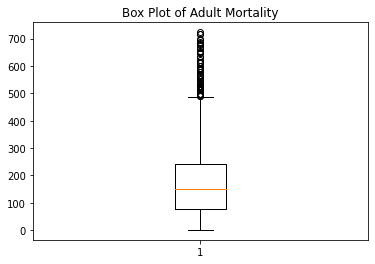

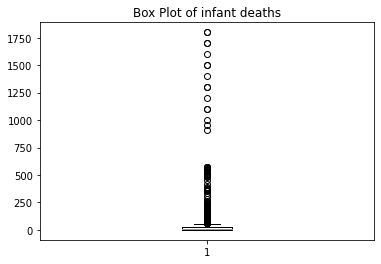

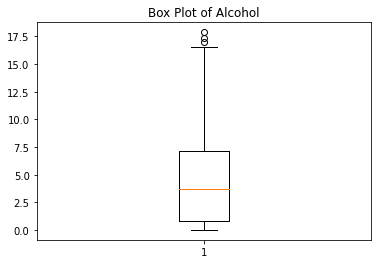

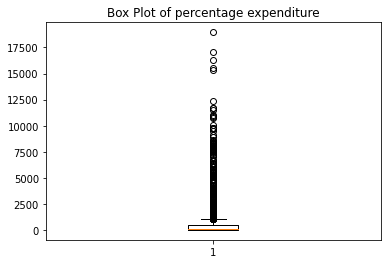

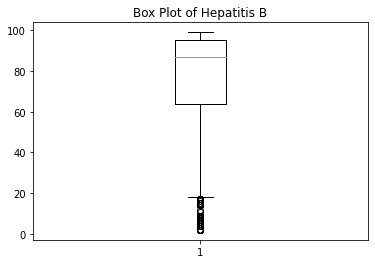

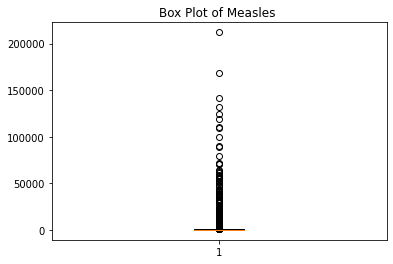

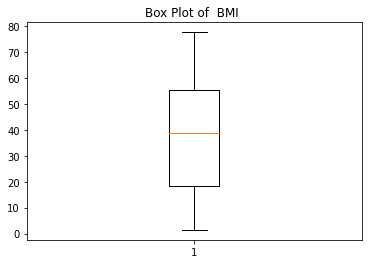

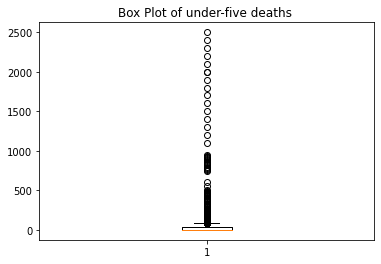

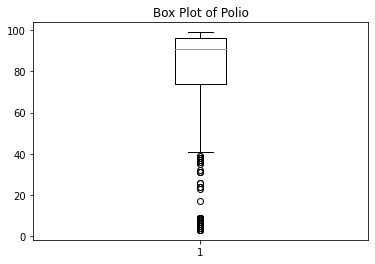

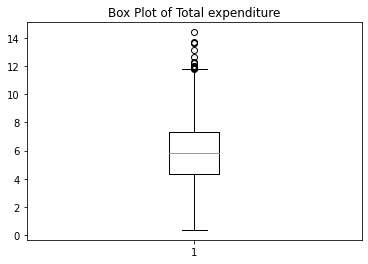

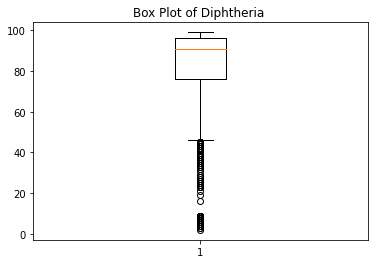

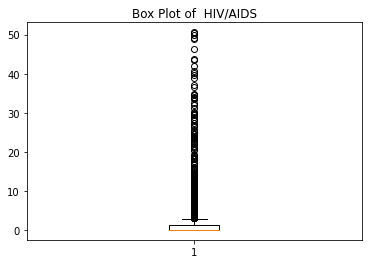

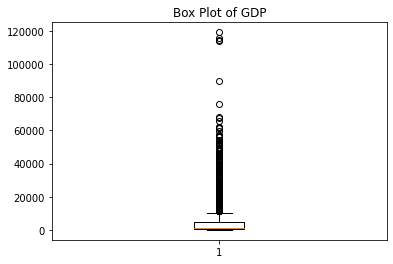

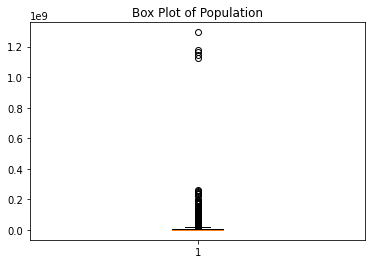

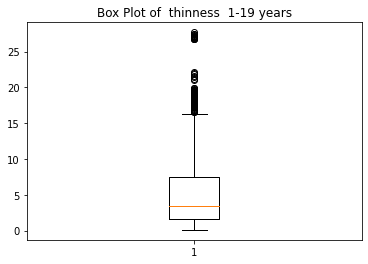

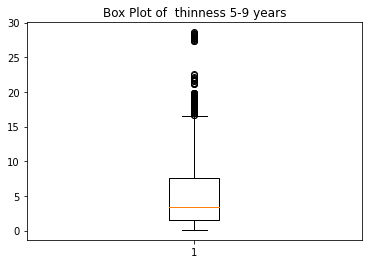

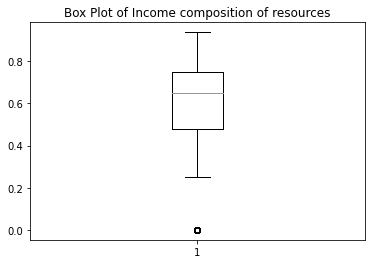

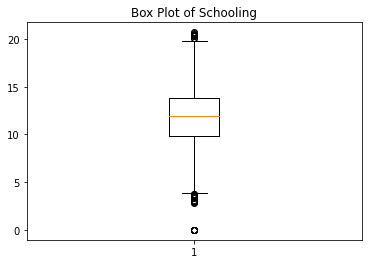

In [ ]:
for col in fill_list2:
  plt.boxplot(le[col])
  plt.title('Box Plot of {}'.format(col))
  plt.show()

Now for handling outliers - if there are only a few I'm going to winsorize the dataset and adjust the max's and min's for outliers. I'll do this for schooling, income composition of resources, total expenditure, Alcohol, and life expectancy. BMI is good, but the others will have to be adjusted using a different method.

I will take the log for the other variables - infant deaths, percentage expenditure, under-five deaths, HIV/AIDS, thinness 5-9 and 1-19, population, GDP, Measles, and Adult Mortality

For diphtheria, polio, and hep B, I will figure out a different method.

In [ ]:
from scipy.stats.mstats import winsorize

le['adjusted_schooling'] = winsorize(le["Schooling"], (0.015, 0.01))
le['adjusted_income_comp_of_resources'] = winsorize(le["Income composition of resources"], (0.045, 0))
le['adjusted_total_expenditure'] = winsorize(le["Total expenditure"], (0, 0.01))
le['adjusted_alcohol'] = winsorize(le["Alcohol"], (0, 0.005))
le['adjusted_life_expectancy'] = winsorize(le["Life expectancy "], (0.005, 0))
le['adjusted_GDP'] = winsorize(np.log(le["GDP"]),(0.003,0))
le['adjusted_Measles'] = np.log(le["Measles "])
le['adjusted_infant_deaths'] = np.log(le["infant deaths"])
le['adjusted_percentage_expenditure'] = winsorize(np.log(le["percentage expenditure"]),(0.075,0))
le['adjusted_under_5_deaths'] = np.log(le["under-five deaths "])
le['adjusted_HIV/AIDS'] = np.log(le[" HIV/AIDS"])
le['adjusted_thinness_5_9'] = winsorize(np.log(le[" thinness 5-9 years"]),(0.015,0))
le['adjusted_thinness_1_19'] = winsorize(np.log(le[" thinness  1-19 years"]),(0.015,0))
le['adjusted_adult_mortality'] = winsorize(np.log(le["Adult Mortality"]),(0.055,0))
le['adjusted_population'] = winsorize(np.log(le["Population"]),(0.015,0))
le['adjusted_diphtheria'] = (le['Diphtheria '])**3
le['adjusted_polio'] = (le['Polio'])**2
le['adjusted_hep_b'] = (le['Hepatitis B'])**2

fill_list2.remove(" BMI ")

le = le.drop(fill_list2, axis=1)

We have now gotten rid of, or adjusted the data so there are no more outliers to mess with the data.

In [ ]:
le.head()

,Country,Year,Status,BMI,adjusted_schooling,adjusted_income_comp_of_resources,adjusted_total_expenditure,adjusted_alcohol,adjusted_life_expectancy,adjusted_GDP,adjusted_Measles,adjusted_infant_deaths,adjusted_percentage_expenditure,adjusted_under_5_deaths,adjusted_HIV/AIDS,adjusted_thinness_5_9,adjusted_thinness_1_19,adjusted_adult_mortality,adjusted_population,adjusted_diphtheria,adjusted_polio,ajusted_hep_b
0,Afghanistan,2015,Developing,19.1,10.1,0.479,8.16,0.01,65.0,6.370345,7.050989,4.127134,4.266611,4.418841,-2.302585,2.850707,2.844909,5.572154,17.334091,274625.0,36.0,4225.0
1,Afghanistan,2014,Developing,18.6,10.0,0.476,8.18,0.01,59.9,6.417870,6.198479,4.158883,4.297606,4.454347,-2.302585,2.862201,2.862201,5.602119,12.699494,238328.0,3364.0,3844.0
2,Afghanistan,2013,Developing,18.1,9.9,0.470,8.13,0.01,59.9,6.448486,6.063785,4.189655,4.293458,4.488636,-2.302585,2.873565,2.873565,5.590987,17.272826,262144.0,3844.0,4096.0
3,Afghanistan,2012,Developing,17.6,9.8,0.463,8.52,0.01,59.5,6.507217,7.932721,4.234107,4.359068,4.532599,-2.302585,2.890372,2.884801,5.605802,15.123021,300763.0,4489.0,4489.0
4,Afghanistan,2011,Developing,17.2,9.5,0.454,7.87,0.01,59.2,4.151626,8.010692,4.262680,1.959687,4.574711,-2.302585,2.901422,2.901422,5.616771,14.906964,314432.0,4624.0,4624.0


2. Explore the data using univariate and multivariate exploration techniques. Be sure to pay special attention to your target variable. In this regard, focus on finding the relevant variables that may affect life expectancy.

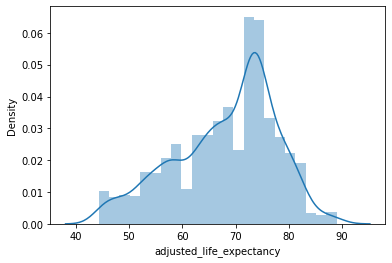

In [ ]:
sns.distplot(le['adjusted_life_expectancy'])

Looks normal-ish

In [ ]:
le = pd.concat([le, pd.get_dummies(le["Status"], drop_first=True)], axis=1)
le.head(1)

,Country,Year,Status,BMI,adjusted_schooling,adjusted_income_comp_of_resources,adjusted_total_expenditure,adjusted_alcohol,adjusted_life_expectancy,adjusted_GDP,adjusted_Measles,adjusted_infant_deaths,adjusted_percentage_expenditure,adjusted_under_5_deaths,adjusted_HIV/AIDS,adjusted_thinness_5_9,adjusted_thinness_1_19,adjusted_adult_mortality,adjusted_population,adjusted_diphtheria,adjusted_polio,ajusted_hep_b,Developing
0,Afghanistan,2015,Developing,19.1,10.1,0.479,8.16,0.01,65.0,6.370345,7.050989,4.127134,4.266611,4.418841,-2.302585,2.850707,2.844909,5.572154,17.334091,274625.0,36.0,4225.0,1


In [ ]:
for col in le.columns[3:]:
  print("Correlations between life expectancy and {} is {}.".format(col,le['adjusted_life_expectancy'].corr(le[col])))

Correlations between life expectancy and  BMI  is 0.5957236819091255.
Correlations between life expectancy and adjusted_schooling is 0.7618855834334566.
Correlations between life expectancy and adjusted_income_comp_of_resources is 0.8242358562767733.
Correlations between life expectancy and adjusted_total_expenditure is 0.21166718855540487.
Correlations between life expectancy and adjusted_alcohol is 0.3979320836967002.
Correlations between life expectancy and adjusted_life_expectancy is 0.9999999999999998.
Correlations between life expectancy and adjusted_GDP is 0.5675077288143351.
Correlations between life expectancy and adjusted_Measles is nan.
Correlations between life expectancy and adjusted_infant_deaths is nan.
Correlations between life expectancy and adjusted_percentage_expenditure is 0.42727308244041073.
Correlations between life expectancy and adjusted_under_5_deaths is nan.
Correlations between life expectancy and adjusted_HIV/AIDS is -0.8162364188529703.
Correlations betwee

Not sure why nan showed up in some - missing values are:

Measles: -0.282784

infant deaths: -0.479539

under 5 deaths: -0.536448


We can see there is little correlation with population, and very high correlation with hiv/aids, schooling, and income composition of resources

In [ ]:
fill_list3 = list(le.columns)
fill_list3.remove("Country")
fill_list3.remove("Year")
fill_list3.remove("Status")
fill_list3.remove('adjusted_life_expectancy')

3. In the feature-engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are highly correlated with the other ones or the variables that you think are irrelevant with the life expectancy.

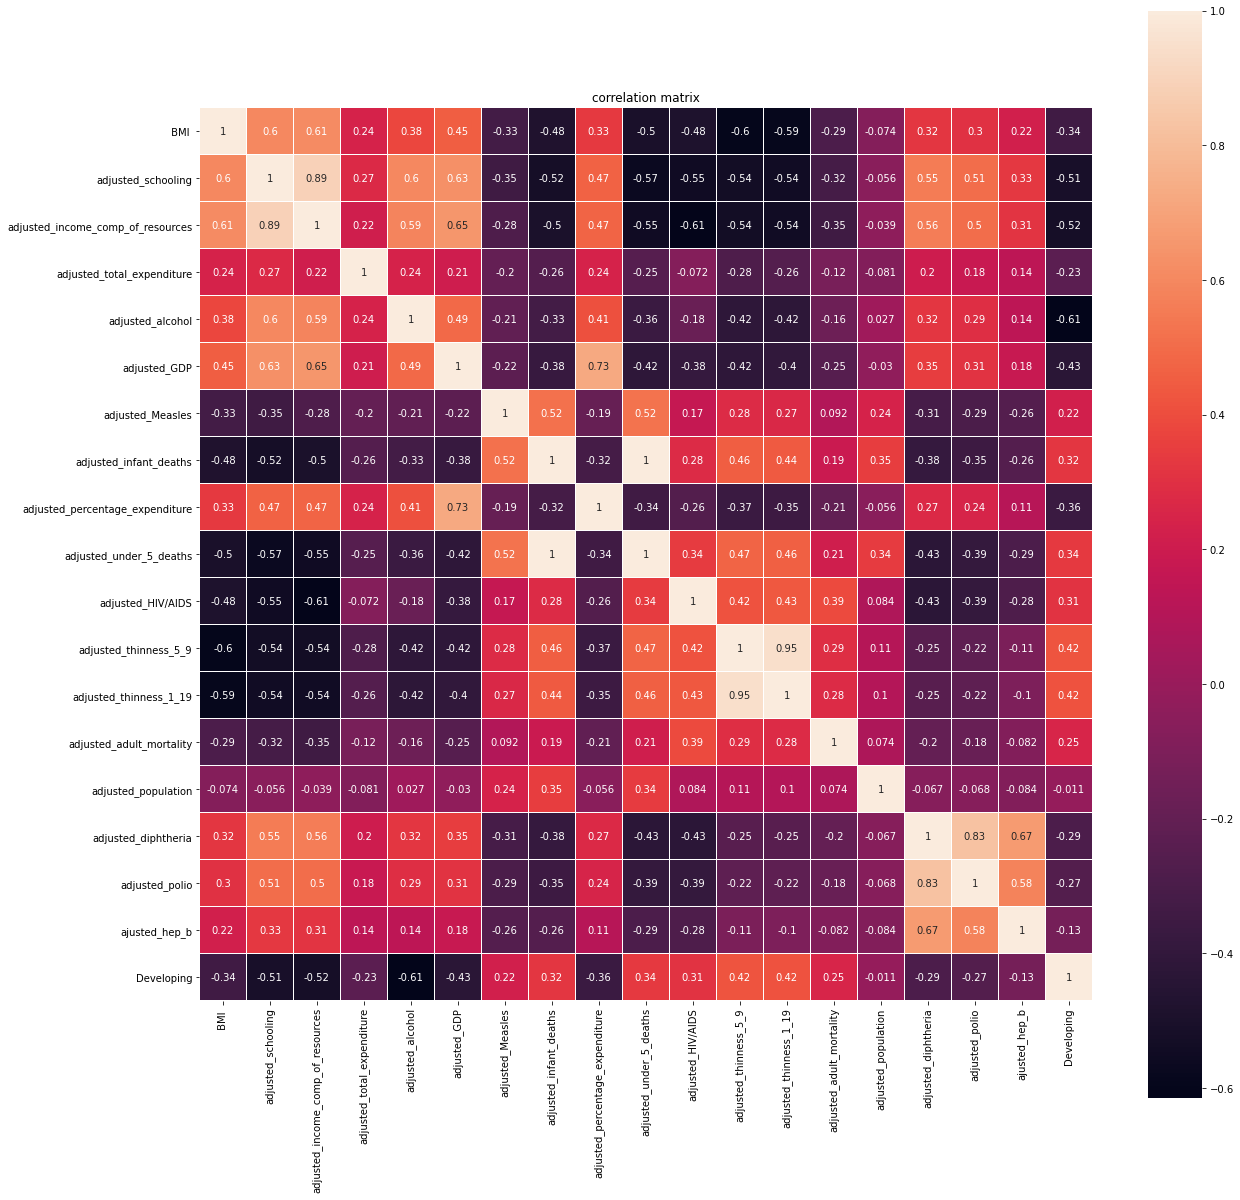

In [ ]:
corrmat_le = le[fill_list3].corr()
plt.figure(figsize=(20,20))

sns.heatmap(corrmat_le, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")

plt.show()

We can see schooling & income comp, polio & diphtheria, and thinness 5-9 & 1-19 are highly correlated, so we can reduce each of those pairs to a single feature. We will get rid of the ones which are less correlated with life expectancy.

In [ ]:
le = le.drop(['adjusted_schooling','adjusted_thinness_1_19','adjusted_polio'], axis=1)

We can also get rid of population, since we saw it is barely correlated with life expectancy.

In [ ]:
le = le.drop('adjusted_population', axis=1)

In [ ]:
for col in le.columns[3:]:
  print("Correlations between life expectancy and {} is {}.".format(col,le['adjusted_life_expectancy'].corr(le[col])))

Correlations between life expectancy and  BMI  is 0.5957236819091255.
Correlations between life expectancy and adjusted_income_comp_of_resources is 0.8242358562767733.
Correlations between life expectancy and adjusted_total_expenditure is 0.21166718855540487.
Correlations between life expectancy and adjusted_alcohol is 0.3979320836967002.
Correlations between life expectancy and adjusted_life_expectancy is 0.9999999999999998.
Correlations between life expectancy and adjusted_GDP is 0.5675077288143351.
Correlations between life expectancy and adjusted_Measles is nan.
Correlations between life expectancy and adjusted_infant_deaths is nan.
Correlations between life expectancy and adjusted_percentage_expenditure is 0.42727308244041073.
Correlations between life expectancy and adjusted_under_5_deaths is nan.
Correlations between life expectancy and adjusted_HIV/AIDS is -0.8162364188529703.
Correlations between life expectancy and adjusted_thinness_5_9 is -0.5542039184750874.
Correlations be

Measles: -0.282784

infant deaths: -0.479539

under 5 deaths: -0.536448


In [ ]:
list_for_pca = list(le.columns[3:])
list_for_pca.remove('adjusted_life_expectancy')
list_for_pca

[' BMI ',
 'adjusted_income_comp_of_resources',
 'adjusted_total_expenditure',
 'adjusted_alcohol',
 'adjusted_GDP',
 'adjusted_Measles',
 'adjusted_infant_deaths',
 'adjusted_percentage_expenditure',
 'adjusted_under_5_deaths',
 'adjusted_HIV/AIDS',
 'adjusted_thinness_5_9',
 'adjusted_adult_mortality',
 'adjusted_diphtheria',
 'ajusted_hep_b',
 'Developing']

4. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

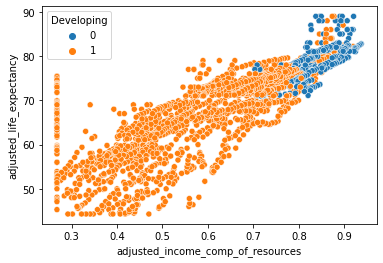

In [ ]:
sns.scatterplot(data=le, x="adjusted_income_comp_of_resources", y="adjusted_life_expectancy", hue='Developing')

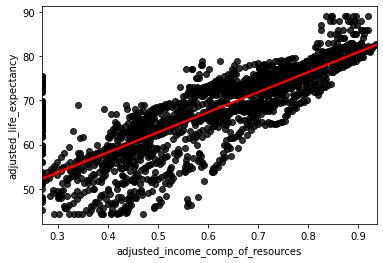

In [ ]:
sns.regplot(x="adjusted_income_comp_of_resources", y="adjusted_life_expectancy", data=le, scatter_kws={"color": "black"}, line_kws={"color": "red"});

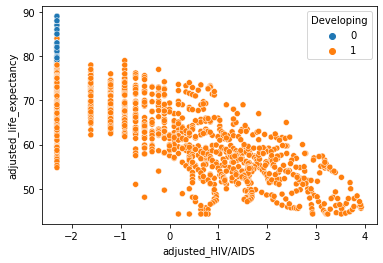

In [ ]:
sns.scatterplot(data=le, x="adjusted_HIV/AIDS", y="adjusted_life_expectancy", hue='Developing')

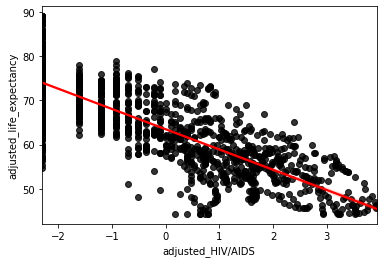

In [ ]:
sns.regplot(x="adjusted_HIV/AIDS", y="adjusted_life_expectancy", data=le, scatter_kws={"color": "black"}, line_kws={"color": "red"});

Now lets look at the data before we took the log of these two features.

In [ ]:
le_orig.head(1)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.25921,33736494.0,17.2,17.3,0.479,10.1


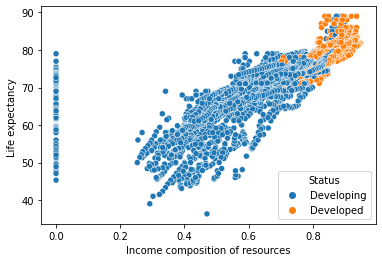

In [ ]:
sns.scatterplot(data=le_orig, x="Income composition of resources", y="Life expectancy ", hue='Status')

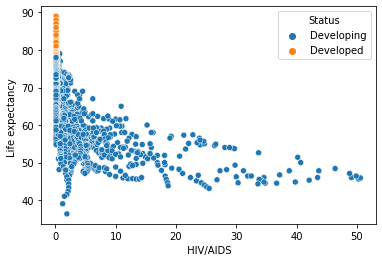

In [ ]:
sns.scatterplot(data=le_orig, x=" HIV/AIDS", y="Life expectancy ", hue="Status")